# Import Libraries
---

In [2]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_colwidth", 200)

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
    cross_val_predict,
)
from sklearn.metrics import (
    fbeta_score,
)
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import joblib

---

# Methodology (Machine Learning)
---

In [5]:
df = pd.read_csv("df_clean.csv")

df["Contract"] = pd.Categorical(
    df["Contract"], categories=["Month-to-month", "One year", "Two year"]
)

df["Satisfaction Score"] = pd.Categorical(
    df["Satisfaction Score"], categories=[5, 4, 3, 2, 1]
)

df["AgeGroup"] = pd.Categorical(
    df["AgeGroup"], categories=["Under 30", "Middle Age (30–59)", "Senior (≥ 60)"]
)

df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customerID          7032 non-null   object  
 1   Partner             7032 non-null   object  
 2   MultipleLines       7032 non-null   object  
 3   InternetService     7032 non-null   object  
 4   OnlineSecurity      7032 non-null   object  
 5   OnlineBackup        7032 non-null   object  
 6   DeviceProtection    7032 non-null   object  
 7   TechSupport         7032 non-null   object  
 8   StreamingTV         7032 non-null   object  
 9   StreamingMovies     7032 non-null   object  
 10  Contract            7032 non-null   category
 11  PaperlessBilling    7032 non-null   object  
 12  PaymentMethod       7032 non-null   object  
 13  tenure              7032 non-null   int64   
 14  MonthlyCharges      7032 non-null   float64 
 15  CLTV                7032 non-null   in

## Feature Selection

In [7]:
X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]

## Data Splitting

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Preprocessing

In [11]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

num_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)

cat_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [("num", num_transformer, num_cols), ("cat", cat_transformer, cat_cols)],
    remainder="passthrough",
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['tenure', 'MonthlyCharges', 'CLTV']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Partner', 'MultipleLines', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod',
                                  'Satisfaction Score', 'AgeGroup'])])

## Modeling & Evaluation

In [13]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
}

### Model Benchmarking

In [15]:
# Setup CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f2_scores = []
roc_aucs = []

# Cross-validated model evaluation
for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])

    # Get cross-validated predictions (probabilities and labels)
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict")
    y_proba = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict_proba")[
        :, 1
    ]

    # Calculate evaluation metrics
    f2 = fbeta_score(y_train, y_pred, beta=2)
    roc = roc_auc_score(y_train, y_proba)

    f2_scores.append(f2)
    roc_aucs.append(roc)

# Compile results into a DataFrame
results_df = (
    pd.DataFrame(
        {
            "Model": list(models.keys()),
            "Mean F2 Score": f2_scores,
            "Mean ROC AUC": roc_aucs,
        }
    )
    .set_index("Model")
    .sort_values(by="Mean F2 Score", ascending=False)
)

print("\nModel Benchmarking Results:")
display(results_df)


Model Benchmarking Results:


,Mean F2 Score,Mean ROC AUC
Model,,
Logistic Regression,0.883474,0.988124
Decision Tree,0.875333,0.915956
Random Forest,0.868500,0.979717
SVM,0.862140,0.973079
KNN,0.790506,0.937779


### Tuning Hyperparameter

In [17]:
# Logistic Regression pipeline
logreg_pipe = Pipeline(
    [("preprocess", preprocessor), ("model", LogisticRegression(max_iter=1000))]
)

# Hyperparameter grid
param_grid_logreg = {
    "model__penalty": ["l1", "l2"],
    "model__C": [0.01, 0.1, 1, 10],
    "model__solver": ["liblinear", "saga"],
}

grid_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid_logreg,
    scoring="f1",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

f2 = fbeta_score(y_test, y_pred, beta=2)
roc_auc = roc_auc_score(y_test, y_proba)

# Show results
results = pd.DataFrame(
    {"Model": ["Tuned Logistic Regression"], "F2 Score": [f2], "ROC AUC": [roc_auc]}
).set_index("Model")

display(results)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,F2 Score,ROC AUC
Model,,
Tuned Logistic Regression,0.878049,0.986885


### Feature Importance

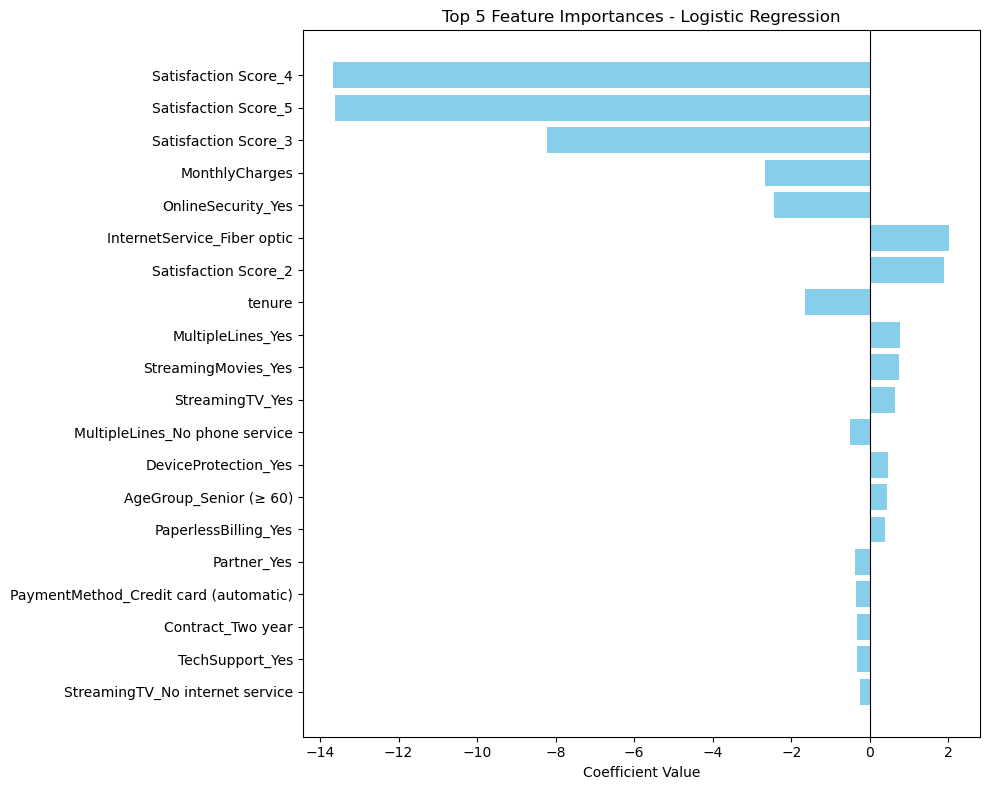

In [19]:
logreg_model = best_model.named_steps["model"]

# Extract encoded categorical feature names
ohe = (
    best_model.named_steps["preprocess"]
    .named_transformers_["cat"]
    .named_steps["onehot"]
)
cat_feature_names = ohe.get_feature_names_out(cat_cols)

all_feature_names = num_cols + cat_feature_names.tolist()

coefficients = logreg_model.coef_[0]

feature_importance_df = pd.DataFrame(
    {
        "Feature": all_feature_names,
        "Coefficient": coefficients,
        "Abs_Coefficient": np.abs(coefficients),
    }
).sort_values(by="Abs_Coefficient", ascending=False)

# Assuming you already have `feature_importance_df` from your trained model
top_features = feature_importance_df.sort_values(
    by="Abs_Coefficient", ascending=False
).head(20)

plt.figure(figsize=(10, 8))
bars = plt.barh(top_features["Feature"], top_features["Coefficient"], color="skyblue")
plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Coefficient Value")
plt.title(f"Top 5 Feature Importances - Logistic Regression")
plt.gca().invert_yaxis()  # Puts most important at the top

plt.tight_layout()
plt.show()

### Save Model

In [21]:
joblib.dump(model, 'model.pkl')

['model.pkl']